# 项目需求：通过XGboost来实现预测zclose值

# 导入各python包

In [154]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping, ModelCheckpoint


# 导入数据

In [155]:
all_data_set_path = r'https://raw.githubusercontent.com/Daming8/ST/main/CSI500.csv'
all_data_set = pd.read_csv(all_data_set_path)

In [156]:
print(all_data_set.head())

       Date      Open      High       Low     Close  Preclose      Volume  \
0  2010/1/4  3592.468  3597.748  3535.229  3535.229  3575.684  6610108000   
1  2010/1/5  3545.186  3577.526  3497.661  3564.038  3535.229  8580964100   
2  2010/1/6  3558.700  3588.832  3541.173  3541.727  3564.038  7847312500   
3  2010/1/7  3543.160  3558.556  3452.769  3471.456  3541.727  8035003700   
4  2010/1/8  3456.908  3482.083  3426.698  3480.130  3471.456  6079025300   

         Amount    PctChg  
0  9.341984e+10 -1.131394  
1  1.283020e+11  0.814914  
2  1.210460e+11 -0.626004  
3  1.204360e+11 -1.984089  
4  9.019096e+10  0.249861  


In [157]:
print(all_data_set.info()) #查看有多少数据及特征

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3159 non-null   object 
 1   Open      3159 non-null   float64
 2   High      3159 non-null   float64
 3   Low       3159 non-null   float64
 4   Close     3159 non-null   float64
 5   Preclose  3159 non-null   float64
 6   Volume    3159 non-null   int64  
 7   Amount    3159 non-null   float64
 8   PctChg    3159 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 222.2+ KB
None


In [158]:
print(all_data_set.isnull().sum()) #检查是否有空数据

Date        0
Open        0
High        0
Low         0
Close       0
Preclose    0
Volume      0
Amount      0
PctChg      0
dtype: int64


# 研究数据

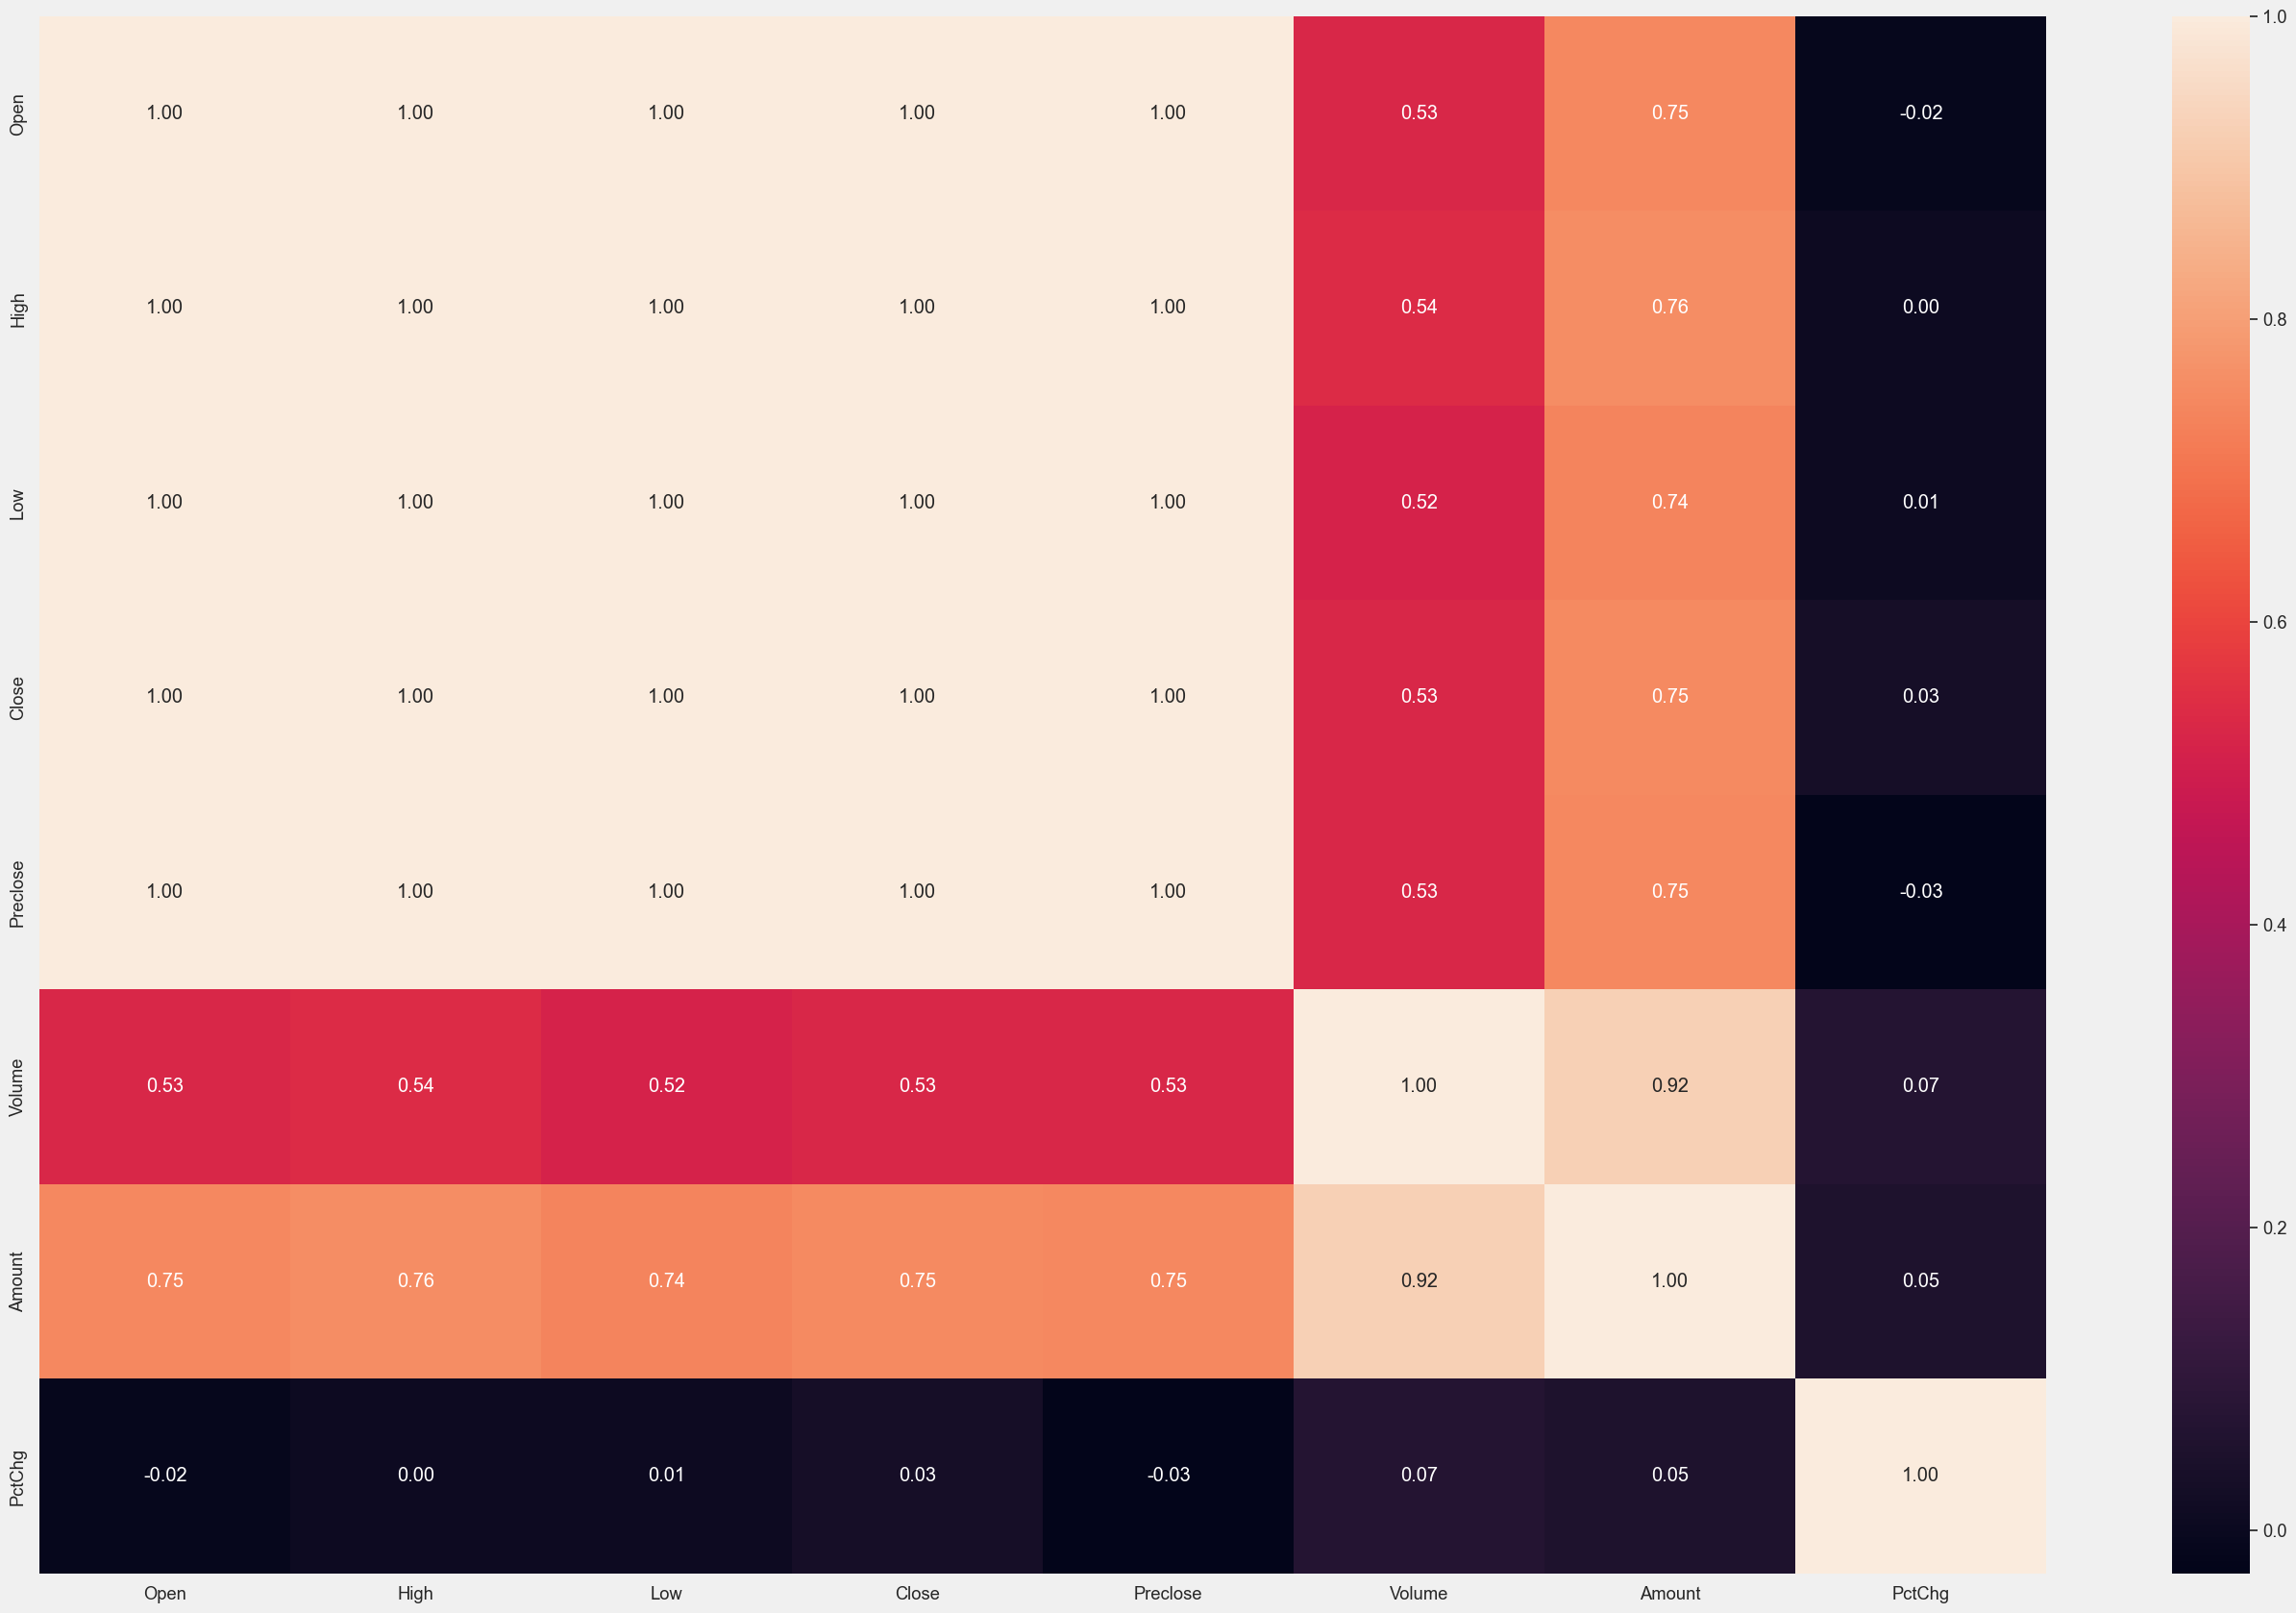

In [159]:
# 特征热力图 相关性分析
list_columns = all_data_set.columns
plt.figure(figsize=(30,20))
sns.set(font_scale=1.2)
sns.heatmap(all_data_set[list_columns].corr(), annot=True, fmt=".2f")
plt.show()

In [160]:
# 对特征重要性进行排序
corr_1 = all_data_set.corr()
corr_1["Close"].sort_values(ascending=False)

Close       1.000000
High        0.999285
Low         0.999262
Open        0.998547
Preclose    0.998161
Amount      0.748374
Volume      0.529411
PctChg      0.030364
Name: Close, dtype: float64

# 数据预处理

In [161]:
len_ = len(['Open','High','Low','Close'])*3
col_numbers_drop = []
for i in range(3):
    col_numbers_drop.append(len_+i)
print(col_numbers_drop)

[12, 13, 14]


In [162]:
all_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3159 non-null   object 
 1   Open      3159 non-null   float64
 2   High      3159 non-null   float64
 3   Low       3159 non-null   float64
 4   Close     3159 non-null   float64
 5   Preclose  3159 non-null   float64
 6   Volume    3159 non-null   int64  
 7   Amount    3159 non-null   float64
 8   PctChg    3159 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 222.2+ KB


In [163]:
# import pandas as pd
# df = all_data_set
# # 假设 df 包含 ['Open', 'High', 'Low', 'Close'] 列
# cols = ['Open', 'High', 'Low', 'Close']

# # 找出每个列中的异常值
# outliers = pd.DataFrame()
# for col in cols:
#     q1 = df[col].quantile(0.25)
#     q3 = df[col].quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
#     col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][[col]]
#     col_outliers.rename(columns={col: f"{col}_outliers"}, inplace=True)
#     outliers = pd.concat([outliers, col_outliers], axis=1, sort=False)

# # 输出异常值
# print(outliers)


In [164]:
# 依据特征重要性，选择zlow zhigh zopen来进行预测zclose
# 数据选择t-n, ...., t-2 t-1 与 t 来预测未来 t+1
# 转换原始数据为新的特征列来进行预测,time_window可以用来调试用前几次的数据来预测
def series_to_supervised(data,time_window=3):
    data_columns = ['Open','High','Low','Close']
    data = data[data_columns]  # Note this is important to the important feature choice
    cols, names = list(), list()
    for i in range(time_window, -1, -1):
        # get the data
        cols.append(data.shift(i)) #数据偏移量
        
        # get the column name
        if ((i-1)<=0):
            suffix = '(t+%d)'%abs(i-1)
        else:
            suffix = '(t-%d)'%(i-1)
        names += [(colname + suffix) for colname in data_columns]
        
    # concat the cols into one dataframe
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    agg.index = data.index.copy()
    # remove the nan value which is caused by pandas.shift
    agg = agg.dropna(inplace=False)

    # remove unused col (only keep the "close" fied for the t+1 period)
    # Note col "close" place in the columns

    len_ = len(data_columns)*time_window
    col_numbers_drop = []
    for i in range(len(data_columns)-1):
        col_numbers_drop.append(len_+i)

    agg.drop(agg.columns[col_numbers_drop],axis=1,inplace = True)
       
    return agg
    

In [165]:
all_data_set2 = all_data_set.copy()
all_data_set2["Date"] = pd.to_datetime(all_data_set2["Date"])       # 日期object: to datetime
all_data_set2.set_index("Date", inplace=True, drop=True) # 把index设为索引

In [166]:
#all_data_set2 = all_data_set2[2698:] # 这里把7月28日的数据全部删掉了，主要是数据缺失较多

In [167]:
data_set_process = series_to_supervised(all_data_set2,10) #取近10分钟的数据
print(data_set_process.columns.values)

['Open(t-9)' 'High(t-9)' 'Low(t-9)' 'Close(t-9)' 'Open(t-8)' 'High(t-8)'
 'Low(t-8)' 'Close(t-8)' 'Open(t-7)' 'High(t-7)' 'Low(t-7)' 'Close(t-7)'
 'Open(t-6)' 'High(t-6)' 'Low(t-6)' 'Close(t-6)' 'Open(t-5)' 'High(t-5)'
 'Low(t-5)' 'Close(t-5)' 'Open(t-4)' 'High(t-4)' 'Low(t-4)' 'Close(t-4)'
 'Open(t-3)' 'High(t-3)' 'Low(t-3)' 'Close(t-3)' 'Open(t-2)' 'High(t-2)'
 'Low(t-2)' 'Close(t-2)' 'Open(t-1)' 'High(t-1)' 'Low(t-1)' 'Close(t-1)'
 'Open(t+0)' 'High(t+0)' 'Low(t+0)' 'Close(t+0)' 'Close(t+1)']


In [168]:
print(data_set_process.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3149 entries, 2010-01-18 to 2022-12-30
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open(t-9)   3149 non-null   float64
 1   High(t-9)   3149 non-null   float64
 2   Low(t-9)    3149 non-null   float64
 3   Close(t-9)  3149 non-null   float64
 4   Open(t-8)   3149 non-null   float64
 5   High(t-8)   3149 non-null   float64
 6   Low(t-8)    3149 non-null   float64
 7   Close(t-8)  3149 non-null   float64
 8   Open(t-7)   3149 non-null   float64
 9   High(t-7)   3149 non-null   float64
 10  Low(t-7)    3149 non-null   float64
 11  Close(t-7)  3149 non-null   float64
 12  Open(t-6)   3149 non-null   float64
 13  High(t-6)   3149 non-null   float64
 14  Low(t-6)    3149 non-null   float64
 15  Close(t-6)  3149 non-null   float64
 16  Open(t-5)   3149 non-null   float64
 17  High(t-5)   3149 non-null   float64
 18  Low(t-5)    3149 non-null   float64
 19  Close(t-5

In [169]:
print(data_set_process.head())

            Open(t-9)  High(t-9)  Low(t-9)  Close(t-9)  Open(t-8)  High(t-8)  \
Date                                                                           
2010-01-18   3592.468   3597.748  3535.229    3535.229   3545.186   3577.526   
2010-01-19   3545.186   3577.526  3497.661    3564.038   3558.700   3588.832   
2010-01-20   3558.700   3588.832  3541.173    3541.727   3543.160   3558.556   
2010-01-21   3543.160   3558.556  3452.769    3471.456   3456.908   3482.083   
2010-01-22   3456.908   3482.083  3426.698    3480.130   3593.106   3594.528   

            Low(t-8)  Close(t-8)  Open(t-7)  High(t-7)  ...  Close(t-2)  \
Date                                                    ...               
2010-01-18  3497.661    3564.038   3558.700   3588.832  ...    3421.144   
2010-01-19  3541.173    3541.727   3543.160   3558.556  ...    3469.051   
2010-01-20  3452.769    3471.456   3456.908   3482.083  ...    3482.738   
2010-01-21  3426.698    3480.130   3593.106   3594.528  ...    3

# 搭建模型XGboost

In [170]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_set_process)

In [171]:
train_size = int(len(data_set_process)*0.8)
test_size = len(data_set_process) - train_size
train_XGB, test_XGB = scaled_data[0:train_size,:],scaled_data[train_size:len(data_set_process),:]

train_XGB_X, train_XGB_Y = train_XGB[:,:(len(data_set_process.columns)-1)],train_XGB[:,(len(data_set_process.columns)-1)]
test_XGB_X, test_XGB_Y = test_XGB[:,:(len(data_set_process.columns)-1)],test_XGB[:,(len(data_set_process.columns)-1)]

# data_set_process_np = data_set_process.to_numpy()
# train_size = int(len(data_set_process_np) * 0.8)
# test_size = len(data_set_process_np) - train_size
# train_XGB, test_XGB = data_set_process_np[0:train_size, :], data_set_process_np[train_size:len(data_set_process_np), :]

# train_XGB_X, train_XGB_Y = train_XGB[:, :(len(data_set_process.columns) - 1)], train_XGB[:, (len(data_set_process.columns) - 1)]
# test_XGB_X, test_XGB_Y = test_XGB[:, :(len(data_set_process.columns) - 1)], test_XGB[:, (len(data_set_process.columns) - 1)]



In [172]:
test_XGB_Y[0:10]

array([0.50973584, 0.50975734, 0.50936425, 0.51448843, 0.52005289,
       0.52679196, 0.52482349, 0.51304617, 0.5149808 , 0.50205476])

In [173]:
# 算法参数
params = {
    'booster':'gbtree',
    'objective':'binary:logistic',  # 此处为回归预测，这里如果改成multi:softmax 则可以进行多分类
    'gamma':0.1,
    'max_depth':4,
    'lambda':2,
    'subsample':0.8,
    'colsample_bytree':0.6,
    'min_child_weight':2,
    'slient':1,
    'eta':0.15,
    'seed':1000,
    'nthread':8,
}
# params = {
#     'booster':'gbtree',
#     'objective':'binary:logistic',  # 此处为回归预测，这里如果改成multi:softmax 则可以进行多分类
#     'gamma':0.1,
#     'max_depth':5,
#     'lambda':3,
#     'subsample':0.7,
#     'colsample_bytree':0.7,
#     'min_child_weight':3,
#     'slient':1,
#     'eta':0.1,
#     'seed':1000,
#     'nthread':4,
# }


In [174]:
#生成数据集格式
xgb_train = xgb.DMatrix(train_XGB_X,label = train_XGB_Y)
xgb_test = xgb.DMatrix(test_XGB_X,label = test_XGB_Y)
num_rounds = 200
watchlist = [(xgb_test,'eval'),(xgb_train,'train')]

In [175]:
#xgboost模型训练
model_xgb = xgb.train(params,xgb_train,num_rounds,watchlist)

[03:25:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "slient" } are not used.

[0]	eval-logloss:0.67235	train-logloss:0.65408
[1]	eval-logloss:0.65660	train-logloss:0.62515
[2]	eval-logloss:0.64372	train-logloss:0.60325
[3]	eval-logloss:0.63238	train-logloss:0.58639
[4]	eval-logloss:0.62391	train-logloss:0.57339
[5]	eval-logloss:0.61725	train-logloss:0.56321
[6]	eval-logloss:0.61149	train-logloss:0.55527
[7]	eval-logloss:0.60674	train-logloss:0.54900
[8]	eval-logloss:0.60311	train-logloss:0.54406
[9]	eval-logloss:0.60063	train-logloss:0.54018
[10]	eval-logloss:0.59825	train-logloss:0.53709
[11]	eval-logloss:0.59604	train-logloss:0.53466
[12]	eval-logloss:0.59409	train-logloss:0.53275
[13]	eval-logloss:0.59291	train-logloss:0.53122
[14]	eval-logloss:0.59182	train-logloss:0.52999
[15]	eval-logloss:0.59066	train-logloss:0.52901
[16]	eval-logloss:0.58972	train-logloss:0.5282

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[60]	eval-logloss:0.58540	train-logloss:0.52514
[61]	eval-logloss:0.58540	train-logloss:0.52514
[62]	eval-logloss:0.58540	train-logloss:0.52514
[63]	eval-logloss:0.58540	train-logloss:0.52514
[64]	eval-logloss:0.58540	train-logloss:0.52514
[65]	eval-logloss:0.58540	train-logloss:0.52514
[66]	eval-logloss:0.58541	train-logloss:0.52514
[67]	eval-logloss:0.58541	train-logloss:0.52514
[68]	eval-logloss:0.58540	train-logloss:0.52514
[69]	eval-logloss:0.58540	train-logloss:0.52514
[70]	eval-logloss:0.58540	train-logloss:0.52514
[71]	eval-logloss:0.58540	train-logloss:0.52514
[72]	eval-logloss:0.58540	train-logloss:0.52514
[73]	eval-logloss:0.58540	train-logloss:0.52514
[74]	eval-logloss:0.58540	train-logloss:0.52514
[75]	eval-logloss:0.58541	train-logloss:0.52514
[76]	eval-logloss:0.58541	train-logloss:0.52514
[77]	eval-logloss:0.58541	train-logloss:0.52514
[78]	eval-logloss:0.58541	train-logloss:0.52514
[79]	eval-logloss:0.58541	train-logloss:0.52514
[80]	eval-logloss:0.58541	train-logloss:

In [176]:
#对测试集进行预测
y_pred_xgb = model_xgb.predict(xgb_test)

In [177]:
y_pred_xgb.shape

(630,)

In [178]:
y_pred_xgb

array([0.50466716, 0.51113504, 0.51113504, 0.51113504, 0.51113504,
       0.52157634, 0.52416885, 0.52416885, 0.51113504, 0.51113504,
       0.50676876, 0.51113504, 0.51113504, 0.52037203, 0.5287842 ,
       0.5312765 , 0.53737843, 0.53737843, 0.53737843, 0.54595584,
       0.55638087, 0.5616915 , 0.6041236 , 0.6533489 , 0.6897133 ,
       0.71133393, 0.72563165, 0.71133393, 0.7399066 , 0.71133393,
       0.71545476, 0.686425  , 0.6749949 , 0.68407357, 0.68407357,
       0.6953285 , 0.68407357, 0.66036326, 0.66036326, 0.67054415,
       0.68407357, 0.68407357, 0.6953285 , 0.71133393, 0.7191136 ,
       0.71133393, 0.72051764, 0.6953285 , 0.70184004, 0.6953285 ,
       0.68407357, 0.68407357, 0.68407357, 0.71133393, 0.7191136 ,
       0.71545476, 0.69375116, 0.6953285 , 0.71133393, 0.7191136 ,
       0.6953285 , 0.7002819 , 0.71796167, 0.7191136 , 0.73856467,
       0.74718994, 0.7410013 , 0.7336032 , 0.7183435 , 0.68407357,
       0.67054415, 0.67054415, 0.68407357, 0.68407357, 0.68407

In [179]:
test_XGB_Y

array([0.50973584, 0.50975734, 0.50936425, 0.51448843, 0.52005289,
       0.52679196, 0.52482349, 0.51304617, 0.5149808 , 0.50205476,
       0.51806816, 0.51888087, 0.52608106, 0.54068168, 0.54157838,
       0.54688604, 0.55150745, 0.54363993, 0.55821959, 0.58074724,
       0.60441476, 0.62692392, 0.69424886, 0.70178269, 0.72217582,
       0.74012031, 0.7165665 , 0.74339653, 0.7309606 , 0.71423777,
       0.65290192, 0.66054755, 0.69699285, 0.6998788 , 0.70616863,
       0.70562849, 0.65003621, 0.65617997, 0.66687877, 0.69664437,
       0.69050115, 0.70095484, 0.72145193, 0.72265911, 0.72301025,
       0.71915493, 0.70441651, 0.70897029, 0.69739037, 0.68821505,
       0.68500817, 0.70353029, 0.73325474, 0.73259097, 0.71321908,
       0.69668372, 0.70735056, 0.7172964 , 0.71893629, 0.70393381,
       0.71071064, 0.74105937, 0.7335206 , 0.74048344, 0.74095772,
       0.73375708, 0.7211585 , 0.69405341, 0.70077832, 0.67126797,
       0.67056617, 0.6827425 , 0.68913049, 0.69919079, 0.69082

In [180]:
test_XGB_Y.shape

(630,)

In [181]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer

# # 定义自定义评分指标
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true))

# mape_scorer = make_scorer(mape, greater_is_better=False)

# # 定义参数空间
# param_dist = {
#     'booster': ['gbtree', 'gblinear', 'dart'],
#     'n_estimators': list(range(100, 1200, 100)),
#     'max_depth': list(range(3, 10)),
#     'min_child_weight': list(range(1, 6)),
#     'gamma': [i / 10.0 for i in range(0, 5)],
#     'subsample': [i / 10.0 for i in range(6, 10)],
#     'colsample_bytree': [i / 10.0 for i in range(6, 10)],
#     'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
#     'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100],
# }

# # 使用随机搜索交叉验证寻找最佳参数
# model = xgb.XGBRegressor()
# random_search = RandomizedSearchCV(model, param_distributions=param_dist,
#                                    n_iter=10, scoring=mape_scorer, cv=5, n_jobs=-1)
# random_search.fit(train_XGB_X, train_XGB_Y)

# # 输出最佳参数和评分
# print("Best parameters found: ")
# print(random_search.best_params_)
# print("Lowest MAPE found: ")
# print(np.abs(random_search.best_score_))


In [182]:
# print("Best parameters found: ", grid_search.best_params_)

In [183]:
mape_xgb = np.mean(np.abs(y_pred_xgb-test_XGB_Y)/test_XGB_Y)*100
print('XGBoost平均误差率为：{}%'.format(mape_xgb))  

XGBoost平均误差率为：3.000053100820312%


In [184]:
mae_xgb = mean_absolute_error(test_XGB_Y, y_pred_xgb)
mse_xgb = mean_squared_error(test_XGB_Y, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(test_XGB_Y, y_pred_xgb)

print('MAE: {:.4f}'.format(mae_xgb))
print('MSE: {:.4f}'.format(mse_xgb))
print('RMSE: {:.4f}'.format(rmse_xgb))
print('R^2: {:.4f}'.format(r2_xgb))

MAE: 0.0222
MSE: 0.0014
RMSE: 0.0375
R^2: 0.9215


In [185]:
# import pandas as pd

# df = pd.DataFrame(y_pred_xgb)
# df.to_csv('y_pred_xgb.csv', index=False)


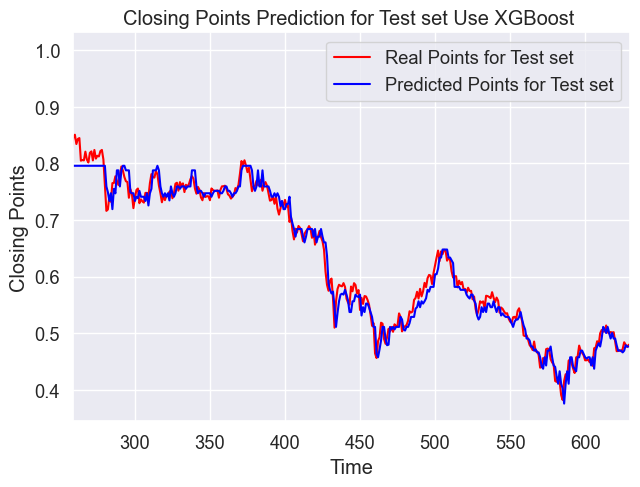

In [186]:
# plt.plot(test_XGB_Y, color = 'red', label = 'Real Points for Test set')
# plt.plot(y_pred_xgb, color = 'blue', label = 'Predicted Points for Test set')
# plt.title('Closing Points Prediction for Test set Use XGBoost ')
# plt.xlabel('Time')
# plt.ylabel('Closing Points')
# plt.legend()
# plt.show()
import matplotlib.pyplot as plt

plt.plot(test_XGB_Y, color='red', label='Real Points for Test set')
plt.plot(y_pred_xgb, color='blue', label='Predicted Points for Test set')
plt.xlim(259, len(test_XGB_Y))  # 设置 X 轴范围
plt.title('Closing Points Prediction for Test set Use XGBoost ')
plt.xlabel('Time')
plt.ylabel('Closing Points')
plt.legend()
plt.show()


In [187]:
joblib.dump(model_xgb, "XGBoost.pkl")

['XGBoost.pkl']

# 搭建模型LSTM网络

In [188]:
# 注意这里要安装Tensorflow 和 Keras才能使用
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [189]:
data_set_process.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3149 entries, 2010-01-18 to 2022-12-30
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open(t-9)   3149 non-null   float64
 1   High(t-9)   3149 non-null   float64
 2   Low(t-9)    3149 non-null   float64
 3   Close(t-9)  3149 non-null   float64
 4   Open(t-8)   3149 non-null   float64
 5   High(t-8)   3149 non-null   float64
 6   Low(t-8)    3149 non-null   float64
 7   Close(t-8)  3149 non-null   float64
 8   Open(t-7)   3149 non-null   float64
 9   High(t-7)   3149 non-null   float64
 10  Low(t-7)    3149 non-null   float64
 11  Close(t-7)  3149 non-null   float64
 12  Open(t-6)   3149 non-null   float64
 13  High(t-6)   3149 non-null   float64
 14  Low(t-6)    3149 non-null   float64
 15  Close(t-6)  3149 non-null   float64
 16  Open(t-5)   3149 non-null   float64
 17  High(t-5)   3149 non-null   float64
 18  Low(t-5)    3149 non-null   float64
 19  Close(t-5

In [190]:
len(data_set_process.columns)

41

In [191]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_set_process)

In [192]:
scaled_data.shape

(3149, 41)

In [193]:
train_size = int(len(data_set_process)*0.8)
test_size = len(data_set_process) - train_size
train_LSTM, test_LSTM = scaled_data[0:train_size,:],scaled_data[train_size:len(data_set_process),:]

train_LSTM_X, train_LSTM_Y = train_LSTM[:,:(len(data_set_process.columns)-1)],train_LSTM[:,(len(data_set_process.columns)-1)]
test_LSTM_X, test_LSTM_Y = test_LSTM[:,:(len(data_set_process.columns)-1)],test_LSTM[:,(len(data_set_process.columns)-1)]
# reshape input to be [samples, time steps, features]
train_LSTM_X2 = np.reshape(train_LSTM_X, (train_LSTM_X.shape[0], 1, train_LSTM_X.shape[1]))
test_LSTM_X2 = np.reshape(test_LSTM_X, (test_LSTM_X.shape[0], 1, test_LSTM_X.shape[1]))


print(train_LSTM_X.shape,train_LSTM_Y.shape,test_LSTM_X.shape,test_LSTM_Y.shape)

(2519, 1, 40) (2519,) (630, 1, 40) (630,)


In [194]:
type(scaler)

sklearn.preprocessing._data.MinMaxScaler

In [195]:
test_LSTM_X[:,:,-4:].shape

(630, 1, 4)

In [196]:
#np.array(data_set_process[-284:]['Close(t+1)']).shape

In [197]:
test_LSTM_X.shape

(630, 1, 40)

In [198]:
# creat and fit the LSTM network
model = Sequential()
#model.add(LSTM(50, input_shape=(train_LSTM_X2.shape[1], train_LSTM_X2.shape[2]),activation='tanh'))
model.add(LSTM(50, input_shape=(train_LSTM_X2.shape[1], train_LSTM_X2.shape[2])))
#update  ！！！！update！！！！！# ！！！！update！！！！！
#model.add(LSTM(30, return_sequences=True, input_shape=(train_LSTM_X2.shape[1], train_LSTM_X2.shape[2])))
#model.add(LSTM(20, return_sequences=False))
# model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mae", optimizer="Adam")
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                18200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________
None


In [199]:
# ！！！！update！！！！！define early stopping and checkpoint callbacks 
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
#model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')


# 结果可视化及评估

In [200]:
type(train_LSTM_Y)

numpy.ndarray

start to fit the model
Epoch 1/200
51/51 - 2s - loss: 0.0363 - val_loss: 0.0310 - 2s/epoch - 41ms/step
Epoch 2/200
51/51 - 0s - loss: 0.0194 - val_loss: 0.0400 - 110ms/epoch - 2ms/step
Epoch 3/200
51/51 - 0s - loss: 0.0232 - val_loss: 0.0218 - 113ms/epoch - 2ms/step
Epoch 4/200
51/51 - 0s - loss: 0.0185 - val_loss: 0.0253 - 115ms/epoch - 2ms/step
Epoch 5/200
51/51 - 0s - loss: 0.0224 - val_loss: 0.0197 - 113ms/epoch - 2ms/step
Epoch 6/200
51/51 - 0s - loss: 0.0154 - val_loss: 0.0333 - 119ms/epoch - 2ms/step
Epoch 7/200
51/51 - 0s - loss: 0.0218 - val_loss: 0.0174 - 123ms/epoch - 2ms/step
Epoch 8/200
51/51 - 0s - loss: 0.0186 - val_loss: 0.0266 - 113ms/epoch - 2ms/step
Epoch 9/200
51/51 - 0s - loss: 0.0256 - val_loss: 0.0262 - 121ms/epoch - 2ms/step
Epoch 10/200
51/51 - 0s - loss: 0.0153 - val_loss: 0.0208 - 118ms/epoch - 2ms/step
Epoch 11/200
51/51 - 0s - loss: 0.0184 - val_loss: 0.0165 - 115ms/epoch - 2ms/step
Epoch 12/200
51/51 - 0s - loss: 0.0166 - val_loss: 0.0280 - 115ms/epoch - 2

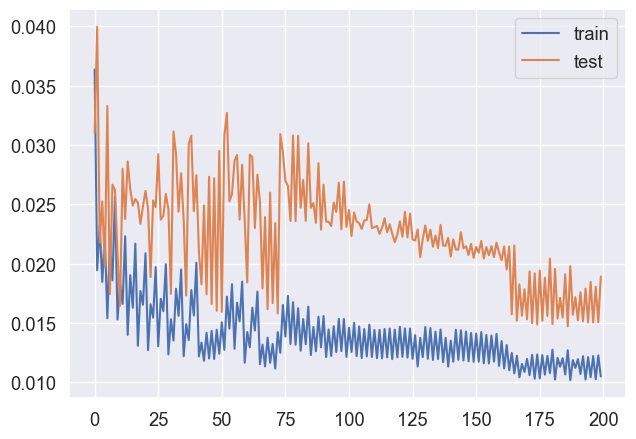

In [201]:
print("start to fit the model")
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights= True)
history = model.fit(train_LSTM_X2, train_LSTM_Y, epochs=200, batch_size=50, validation_data=(test_LSTM_X2, test_LSTM_Y),verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [202]:
#model.save('LSTM_model.h5')

# ！！！update！！！load the best model saved during training
#model.load_weights('best_model.h5') 

In [205]:
yPredict = model.predict(test_LSTM_X2)
print(yPredict.shape)
print(test_LSTM_Y.shape)
print(test_LSTM_X.shape)

20/20 [==============================] - 0s 1ms/step
(630, 1)
(630,)
(630, 1, 40)


In [206]:
# Reshape yPredict to have shape (606,)
yPredict_reshaped = np.reshape(yPredict, (630,))

# Reshape test_LSTM_X to have shape (606, 40)
test_LSTM_X_reshaped = np.reshape(test_LSTM_X, (630, 40))

# Concatenate test_LSTM_X_reshaped and yPredict_reshaped along the second axis
concatenated = np.concatenate((test_LSTM_X_reshaped, yPredict_reshaped.reshape(630, 1)), axis=1)

# Use the scaler to invert the transformation
testPredict = scaler.inverse_transform(concatenated)[:, -1:]
test_LSTM_Y2 = scaler.inverse_transform(np.concatenate((test_LSTM_X_reshaped, test_LSTM_Y.reshape(len(test_LSTM_Y), 1)), axis=1))[:, -1]


In [207]:
mape = np.mean(np.abs(test_LSTM_Y2.flatten()-testPredict.flatten())/test_LSTM_Y2.flatten())*100  # 这里计算测试集预测结果与真实结果的误差率
print('Test LSTM for test set Score:%.6f MAPE' %(mape)) 

Test LSTM for test set Score:1.473251 MAPE


In [208]:
yPredict_train = model.predict(train_LSTM_X2)
print(yPredict_train.shape)
print(train_LSTM_X.shape)
print(train_LSTM_Y.shape)

79/79 [==============================] - 0s 1ms/step
(2519, 1)
(2519, 1, 40)
(2519,)


In [209]:
train_LSTM_X_reshaped = train_LSTM_X.reshape(train_LSTM_X.shape[0], train_LSTM_X.shape[2])
trainPredict = scaler.inverse_transform(np.concatenate((train_LSTM_X_reshaped, yPredict_train), axis=1))[:, -1:]
train_LSTM_Y2 = scaler.inverse_transform(np.concatenate((train_LSTM_X_reshaped, train_LSTM_Y.reshape(len(train_LSTM_Y),1)), axis=1))[:, -1:]


In [210]:
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import GridSearchCV

# # define the model
# def create_model(units=50, dropout=0.2, recurrent_dropout=0.2, activation='relu'):
#     model = Sequential()
#     model.add(LSTM(units, input_shape=(train_LSTM_X2.shape[1], train_LSTM_X2.shape[2]), dropout=dropout, recurrent_dropout=recurrent_dropout, activation=activation))
#     model.add(Dense(1))
#     model.compile(loss="mae", optimizer="Adam")
#     return model

# # create the model
# model = KerasRegressor(build_fn=create_model, verbose=0)

# # define the grid search parameters
# batch_size = [40, 50, 60]
# epochs = [40,50, 60, 80]



# param_grid = dict(batch_size=batch_size, epochs=epochs, units=units, dropout=dropout, recurrent_dropout=recurrent_dropout, activation=activation)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

# # fit the model
# grid_result = grid.fit(train_LSTM_X2, train_LSTM_Y)

# # print the best parameters and score
# print("Best: %f using %s" % (abs(grid_result.best_score_), grid_result.best_params_))


In [211]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from keras.optimizers import Adam
# def create_lstm_model(neurons=50, optimizer=Adam(lr=0.001)):
#     model = Sequential()
#     model.add(LSTM(neurons, input_shape=(train_LSTM_X2.shape[1], train_LSTM_X2.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss="mae", optimizer=optimizer)
#     return model
# lstm_model = KerasClassifier(build_fn=create_lstm_model, verbose=0)
# param_grid = {
#     'neurons': [ 50,60],
#     'optimizer': [Adam(lr=0.1), Adam(lr=0.01), Adam(lr=0.001)],
#     'epochs': [40, 50, 80],
#     'batch_size': [40,50, 80, 100]
# }
# random_search = RandomizedSearchCV(estimator=lstm_model, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1)
# random_search.fit(train_LSTM_X2, train_LSTM_Y)
# print("Best parameters found: ", random_search.best_params_)
# print("Best score found: ", random_search.best_score_)
# best_model = create_lstm_model(neurons=random_search.best_params_['neurons'], optimizer=random_search.best_params_['optimizer'])
# history = best_model.fit(train_LSTM_X2, train_LSTM_Y, epochs=random_search.best_params_['epochs'], batch_size=random_search.best_params_['batch_size'], validation_data=(test_LSTM_X2, test_LSTM_Y), verbose=2, shuffle=False)


In [212]:
mape2 = np.mean(np.abs(train_LSTM_Y2.flatten()-trainPredict.flatten())/train_LSTM_Y2.flatten())*100  # 这里计算训练集预测结果与真实结果的误差率
print('Test LSTM for train set Score:%.6f MAPE' %(mape2)) 


Test LSTM for train set Score:1.219143 MAPE


In [213]:
mae_lstm = mean_absolute_error(test_LSTM_Y2, testPredict)
mse_lstm = mean_squared_error(test_LSTM_Y2, testPredict)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(test_LSTM_Y2, testPredict)

print('MAE: {:.4f}'.format(mae_lstm))
print('MSE: {:.4f}'.format(mse_lstm))
print('RMSE: {:.4f}'.format(rmse_lstm))
print('R^2: {:.4f}'.format(r2_lstm))

MAE: 70.3608
MSE: 8347.9167
RMSE: 91.3669
R^2: 0.9663


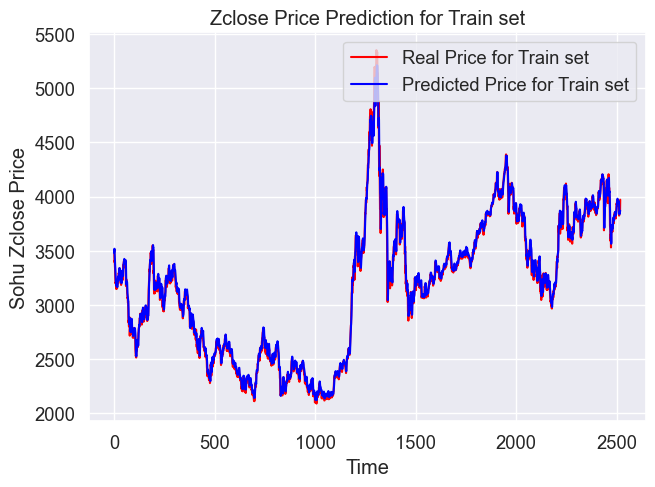

In [214]:
plt.plot(train_LSTM_Y2, color = 'red', label = 'Real Price for Train set')
plt.plot(trainPredict, color = 'blue', label = 'Predicted Price for Train set')
plt.title('Zclose Price Prediction for Train set')
plt.xlabel('Time')
plt.ylabel('Sohu Zclose Price')
plt.legend()
plt.show()

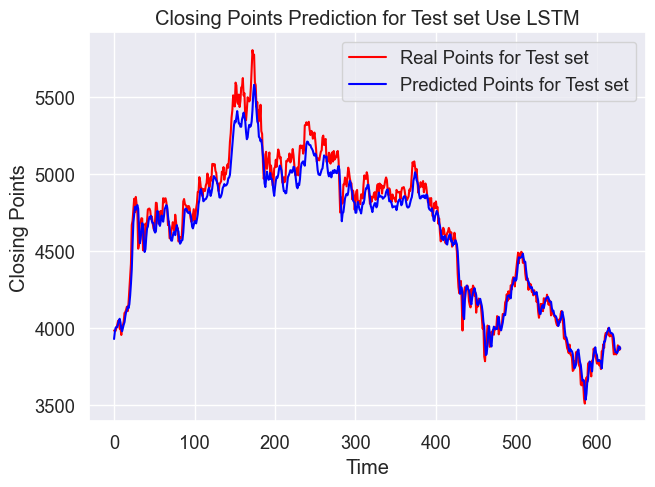

In [215]:
plt.plot(test_LSTM_Y2, color = 'red', label = 'Real Points for Test set')
plt.plot(testPredict, color = 'blue', label = 'Predicted Points for Test set')
plt.title('Closing Points Prediction for Test set Use LSTM')
plt.xlabel('Time')
plt.ylabel('Closing Points')
plt.legend()
plt.show()

# 模型调优

In [216]:
def predictions(mae_lstm, mae_xgboost, prediction_xgb, prediction_lstm):
    if len(prediction_xgb) > 0 and len(prediction_lstm) > 0:
        prediction = (1-(mae_xgboost/(mae_lstm+mae_xgboost)))*prediction_xgb+(1-(mae_lstm/(mae_lstm+mae_xgboost)))*prediction_lstm
        return prediction
    else:
        print("Error: One or more input arrays is empty")
        return []

In [217]:
#COMBINATION LSTM-XGBoost

In [218]:
mae_xgboost = mae_xgb
pred_test_xgb = y_pred_xgb
pred_test_lstm = testPredict


In [219]:
xgboost_model = joblib.load("XGBoost.pkl")

In [220]:
# import numpy as np
# from sklearn.metrics import mean_squared_error

# initial_mse = mean_squared_error(test_LSTM_Y3, lg_pred_V1)


# num_to_remove = int(len(test_LSTM_Y3) * 0.20)
# sorted_errors = np.argsort(np.abs(test_LSTM_Y3 - lg_pred_V1))
# indices_to_remove = sorted_errors[-num_to_remove:]


# test_LSTM_Y3 = np.delete(test_LSTM_Y3, indices_to_remove)
# lg_pred_V1 = np.delete(lg_pred_V1, indices_to_remove)


# new_mse = mean_squared_error(test_LSTM_Y3, lg_pred_V1)


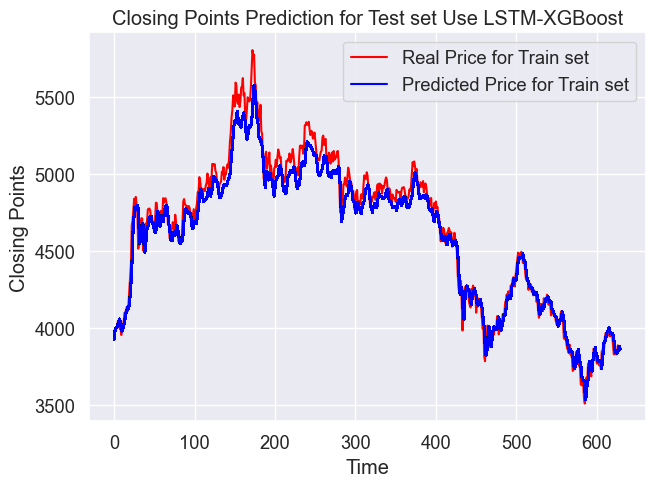

In [221]:
import matplotlib.pyplot as plt



# Assuming mae_lstm, mae_xgboost, pred_test_lstm, and pred_test_xgb are already defined
scope = predictions(mae_lstm, mae_xgboost, pred_test_lstm, pred_test_xgb)
lg_pred = scope

plt.plot(test_LSTM_Y2, color='red', label='Real Price for Train set')
plt.plot(lg_pred, color='blue', label='Predicted Price for Train set')
plt.title('Closing Points Prediction for Test set Use LSTM-XGBoost')
plt.xlabel('Time')
plt.ylabel('Closing Points')
plt.legend().remove()
plt.legend(['Real Price for Train set', 'Predicted Price for Train set'])
plt.show()


In [222]:
avg_mae = (mae_lstm + mae_xgboost)/2

In [223]:
print(lg_pred.shape)
print(test_LSTM_Y2.shape)

(630, 630)
(630,)


In [224]:
lg_pred = lg_pred[:,0]
print(lg_pred.shape)

(630,)


In [225]:
test_LSTM_Y3 = np.round(test_LSTM_Y2)
lg_pred_V1 = np.round(lg_pred)
print(test_LSTM_Y3.shape)
print(lg_pred_V1.shape)

(630,)
(630,)


In [226]:
import numpy as np
from sklearn.metrics import mean_squared_error

initial_mse = mean_squared_error(test_LSTM_Y3, lg_pred_V1)


num_to_remove = int(len(test_LSTM_Y3) * 0.05)
sorted_errors = np.argsort(np.abs(test_LSTM_Y3 - lg_pred_V1))
indices_to_remove = sorted_errors[-num_to_remove:]


test_LSTM_Y3 = np.delete(test_LSTM_Y3, indices_to_remove)
lg_pred_V1 = np.delete(lg_pred_V1, indices_to_remove)


new_mse = mean_squared_error(test_LSTM_Y3, lg_pred_V1)




In [227]:
mae_lgx = mean_absolute_error(test_LSTM_Y3, lg_pred_V1)
mse_lgx = mean_squared_error(test_LSTM_Y3, lg_pred_V1)
rmse_lgx = np.sqrt(mse_lgx)
r2_lgx = r2_score(test_LSTM_Y3, lg_pred_V1)

print('MAE: {:.4f}'.format(mae_lgx))
print('MSE: {:.4f}'.format(mse_lgx))
print('RMSE: {:.4f}'.format(rmse_lgx))
print('R^2: {:.4f}'.format(r2_lgx))

MAE: 62.4841
MSE: 5927.1319
RMSE: 76.9879
R^2: 0.9739


In [228]:
mape3 = np.mean(np.abs(test_LSTM_Y3.flatten()-lg_pred_V1.flatten())/test_LSTM_Y3.flatten())*100  # 这里计算训练集预测结果与真实结果的误差率
print('Test LSTM for train set Score:%.6f MAPE' %(mape3)) 

Test LSTM for train set Score:1.330141 MAPE
